# Modelling Workshop

By Juan Vidal-Perez ([open in Google Collab](https://colab.research.google.com/github/Juan-VidalPerez/Modelling_workshop/blob/main/Modelling_workshop_COMPLETE.ipynb#scrollTo=ed9bb95e))

**This is a completed version of the wrokshop (with spoilers ⚠️).**

## Getting started
To execute a "cell", you'll press Shift-Enter.

### Hosted Colab
If you're working from a hosted colab (recommended):
1. File > Save a copy in Drive
2. Connect (top right) > Connect to a hosted runtime (GPU)

### Run locally as a Jupyter Notebook

You can also open the notebook in jupyter notebook or a locally hosted colab. To run locally, you can open a terminal window and download the code with:


```
pip install notebook
git clone https://github.com/Juan-VidalPerez/Modelling_workshop
cd Modelling_workshop
jupyter notebook Modelling_workshop.ipynb

```

## Hints

**Need help?** To view information about a function or class, type `?` before the name of the function or class (For example, `?print` or `?str` will cause information about the print function or the string datatype to pop up on the right.)

**Table of Contents:** To view the Table of contents for the tutorial, you can click the icon in the top left with three dots next to three lines.

## Resources

These worskshop is loosely based on "Ten simple rules for the computational modeling of behavioral data" by Wilson and Collins (https://elifesciences.org/articles/49547). The paper explores the topic of modelling in more depth, so you can take a look if you are interested!

# INTRODUCTION AND OVERVIEW

The goal of computational modeling in behavioral science is to use precise mathematical models to make better sense of behavioral data. The behavioral data most often come in the form of choices, but can also be reaction times, eye movements, or other easily observable behaviors, and even neural data. The models come in the form of mathematical equations that link the experimentally observable variables (e.g. stimuli, outcomes, past experiences) to behavior in the immediate future. In this sense, computational models instantiate different ‘algorithmic hypotheses’ about how behavior is generated.

Computational modelling is a very extensive topic, but in this workshop we will go over three uses of modelling that dominate the literature:

* **Part 1: Simulations.** We will learn how to simulate data from a *synthetic agent* playing an n-armed bandit task. We will understand how the Rescorla-Wagner model works, and how it can inform action selection. Finally, we will get an intuition of how the parameters of the model can have an impact on behavior.

* **Part 2: Parameter fitting.** We will fit a dataset to our model and take a look at what parameters best explain the behavior in the dataset. We will also take a look at best practices, such as parameter recovery.

* **Part 3: Model comparison.** We will learn how to decide which of several models best explains a dataset.

# Imports

Go ahead and run the cells below to load the required packages (make sure that you have downloaded the entire folder with all the code).

In [10]:
import sys
import os


try:
    from google.colab import files
    _ON_COLAB = True
except ImportError:
    _ON_COLAB = False

if _ON_COLAB:
    if os.path.exists('Modelling_workshop'):
        !rm -rf Modelling_workshop
    !git clone https://github.com/Juan-VidalPerez/Modelling_workshop
    sys.path.append('/content/Modelling_workshop')

!pip install -r Modelling_workshop/requirements.txt

Cloning into 'Modelling_workshop'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 61 (delta 31), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (61/61), 1.22 MiB | 7.56 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
import plotting
import models
from tqdm import tqdm
from IPython.display import Image

Note: If you get the error "no module found", just run ```pip install [module name]```.

## PART 0: WELCOME TO REINFORCEMENT LEARNING (RL)

In this workshop, we will focus on Reinforcement Learning (RL) tasks. RL is a type of learning where individuals learn to make decisions by receiving rewards or punishments for their actions. By modeling RL, we can study how humans and animals learn from experience, optimize their actions to achieve goals, and adapt to changing environments. This approach provides insights into motivation, learning processes, and decision-making strategies.

### The n-armed bandit problem

The n-armed bandit task is a classic problem in reinforcement learning and behavioral psychology. Imagine you are in a casino with several slot machines (also called "bandits"), each with a different probability of paying out a reward when played. Your goal is to maximize your total reward over a series of plays. However, you don't know the payout probabilities of the machines in advance, so you must learn which machines are the most rewarding through trial and error.

You can design bandit tasks with different number of bandits and reward policies (i.e., constant reward probabilities, drifting, reversal tasks...). Here we will focuss on a two-armed badnit task (i.e., with only two bandits) with constant reward probabilities.

### Rescorla-Wagner

The Rescorla-Wagner rule is a model of classical conditioning that describes how the strength of an association between a stimulus and an outcome is updated over time. In the context of a two-armed bandit task, this rule can be used to model how individuals learn to associate each of the two options (or "arms") with their respective rewards.

The Rescorla-Wagner Model includes three main variables:

* $Q_t(a)$: the Q-value of bandit *a* on trial *t*, which represents the expected reward associated with that bandit in that trial (i.e., the prediction of how likely the bandit is to give a reward).

* $R_t$: the outcome (i.e., reward or nothing) received after choosing a bandit on trial *t*.

* $\alpha$: the learning rate, which determines how quickly the model updates the Q-values based on new information.

The Rescorla-Wagner rule relies on a prediction error ($\delta_t$), which is the difference between the actual reward ($R_t$) and the predicted reward ($Q_t$) of the chosen bandit ($a_t$) on trial *t*:

$$\delta_t = R_t - Q_t(a_t)$$

With the reward prediction error $\delta_t$, we can update the value of the chosen option $Q_t(a_t)$ to obtain $Q_{t+1}(a_t)$:

$$Q_{t+1}(a_t) = Q_t(a_t) + \alpha*\delta_t$$

For the update, we *could* simply add the reward prediction error $\delta_t$ to our old value estimate $Q_t$, to immediately arrive at $R_t$, the true outcome. However, we don't really want to move *all the way* from the old value $V_t$ to the actual outcome $r_t$. We only want to move *a little bit*, in order to keep around some of the things we have already learned in the past.

This is the reason why we first multiply $\delta_t$ by $\alpha$, the *learning rate*, before we add it to $Q_t(a_t)$. (The learning rate $\alpha$ is a number between 0 and 1 that "scales" the reward prediction error. For example, if $\alpha=0.25$, we move a quarter of the way from $Q_t$ to $R_t$.)



We'll see what this looks like for a single trial. First, we'll define an agent in the cell below. Then, we'll see how Q-values are modified after a single trial containing one reward outcome.

**Exercise 1:** Complete the code below to implement the Rescorla-Wagner update for a single trial.

**Exercise 2:** change the learning rate to different values. How does the update change? What happens when the elarning rate is 1? And when it is 0?

In [12]:
#@title Agent behavior: **One trial.**

# We define the variables
Q0=0.5 # Original Q-value
R=1 # Bandit outcome (non-reward=0, reward=1)
alpha=0.25 # Learning rate between 0 and 1

# Rescorla-Waner update
Q = Q0 + alpha*(R-Q0)# Compute the update rule
print("Agent's initial Q-value:", Q0)
print("Agent's new Q-values:", Q)

Agent's initial Q-value: 0.5
Agent's new Q-values: 0.625


### Action choice

But how do people use he bandits' Q-values to guide their decisions? A choice rule would be to simply select the bandit with the highest Q-value, since this the bandit that is expected to give more rewards (based on the information gathered so far). However, most people do not do this. Our Q-values may be wrong, so it is useful to occasionally make 'mistakes' (or explore) by choosing low-value options (i.e., to explore). One choice rule with these properties is known as the ‘softmax’ choice rule, which chooses bandit *a^i* with probability:

$$p(a^i)=\frac{exp(\beta*Q_t(a^i))}{\sum_{k=1}^K exp(\beta*Q_t(a^k))}$$

In this mathematical notation, the numerator contains the exponantial of the Q-value of bandit *a^i* (multiplied by a parameter $\beta$, while the denominator contains the sum of the same exponential (and the same $\beta$ parameter) applied to all available bandits. In our two bandit task, this is equivalent to writting:

$$p(a^1)=\frac{1}{1 + exp(\beta*(Q_t(a^2)-Q_t(a^1))}$$

$$p(a^2)=1-p(a^1)$$

As you can see, the probability of choosing a given bandit (i.e., bandit $a^1$) depends on the difference in Q-values bwteeen the bandits ($Q_t(a^2)-Q_t(a^1)$).

$\beta$ is what we call the ‘inverse temperature’ parameter. Let's try to figure out what it does. Let's plot the different probabilities of choosing one bandit as a function of the difference in Q values between the two bandits.

**Exercise 1:** Complete the code below to implement the softmax update the different Q-value differences (**Q_diff**).

**Exercise 2:** change the inverse temperature parameter ($\beta$) and see how the function changes. What happens if you use a $\beta$ of 0? And a very large $\beta$ (e.g., of 1000)?

Text(0.5, 1.0, 'Softmax choice rule')

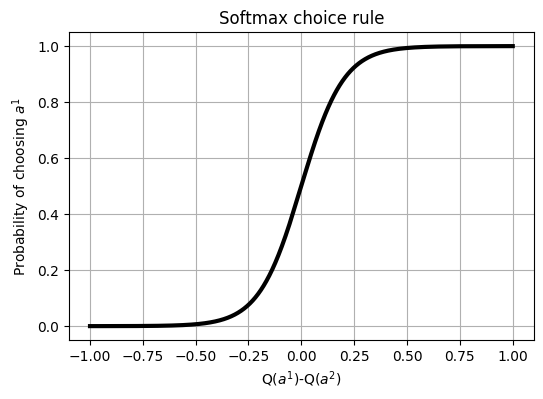

In [13]:
beta=10 # Choose a value of the inverse temperature parameters
Q_diff=np.arange(-1,1,0.001) # Compute the different Q-value differences
p_choice= 1/(1+np.exp(beta*Q_diff)) # Complete the code with the softmax choice rule

#Plot
plt.figure(figsize=(6,4))
plt.plot(-Q_diff,p_choice, color='k',linewidth=3)
plt.grid()
plt.xlabel(f'Q($a^1$)-Q($a^2$)')
plt.ylabel(f'Probability of choosing $a^1$')
plt.title('Softmax choice rule')

It controls the level of stochasticity in the choice, ranging from β=0 for completely random responding and β=∞ for deterministically choosing the highest value option.

## PART 1: SIMULATIONS

A really important step in computational modelling is to create fake, or surrogate data. That is, you should use the models that you are considering to simulate the behavior of participants in the experiment, and to observe how behavior changes with different models, different model parameters, and different variants of the experiment. This is important since it will allow us to form concrete predictions about what our models predict, which we can then compare with actual behavioral data.

Below you can see a function simulating our Rescorla-Wagner model (RW model). The function taskes as input the learning rate (**alpha**) and the inverse temperature (**beta**) parameters. It outputs a numpy array containing a the choice made on each trial based on the model (as well, as their associated outcomes, the accuracy of each choice and the Q-values of each bandit).

Take a look at the function to see if you understand it:

In [14]:
def RW_simulation (alpha: float, beta: float,
                       p_reward: list[float]=[0.25, 0.75], n_blocks: int=20, n_trials: int=30):
    """
    Simulates an n-armed bandit task.

    Input:
    alpha: learning rate for the simulation.
    beta: inverse temperature parameter for softmax.

    Optional inputs:
    p_reward: list specifying reward probabilities of the bandits (default: [0.25, 0.75])
    n_blocks: number of blocks in the task (default: 10)
    n_trials: number of trials per block in the task (default: 30)


    Returns:
    output: numpy array with the results, with the following structure
        - Dimension 0: block number
        - Dimension 1: trial number
        - Dimension 2: [choices,outcomes,accuracy,q_values]
    """
    n_bandits = len(p_reward) #number of bandits

    output = np.full([n_blocks,n_trials, 3+n_bandits], np.nan) #initialize numpy array to store outputs

    for bb in range(n_blocks):
        Q_values=0.5*np.ones(n_bandits) # Initialize Q-values at the beginning of each block
        for tt in range(n_trials):
            # Calculate the probability of choosing each bandit (based on softmax)
            p_choice = softmax(beta*Q_values)
            # Choose one of the bandits given the calculated probabilities
            choice = np.random.choice(n_bandits, p=p_choice)

            # Generate an outcome from the bandit
            outcome = np.random.choice(2, p=[1-p_reward[choice], p_reward[choice]])

            # Update the Q-value of the chosen bandit based on the outcome
            Q_values[choice]+= alpha*(outcome-Q_values[choice])

            # Check accuracy (i.e., whether the chosen bandit is the most rewarding one)
            accuracy = choice==p_reward.index(max(p_reward))

            # Store information in numpy array
            output[bb,tt,0]=choice
            output[bb,tt,1]=outcome
            output[bb,tt,2]=accuracy
            output[bb,tt,3:]=Q_values

    return output



def softmax(x):
    # Subtract the max value from each element for numerical stability
    x_max = np.max(x)
    e_x = np.exp(x - x_max)
    return e_x / e_x.sum(axis=0)

Now let's simulate an agent playing a block of 30 trials:

In [15]:
dataset=RW_simulation (alpha=0.3,beta=2, n_trials=30, n_blocks=1)

### Latent variables

To check how the agent performs, we can take a look at how its Q-values for the different bandits evolved throughout the block. Execute the cell below to plot such values.

**Questions:**
* What do the orange and blue line represent?
* What do the vertical green and red ticks represent?
* What is the relationship between the orange/blue and red/green lines

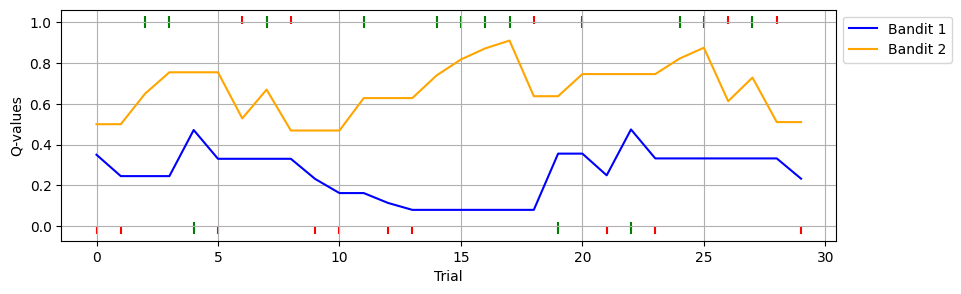

In [16]:
plotting.plot_q_values(dataset)

As you can see, we can use our model to compute  to compute the values of hidden variables (for example values of different choices) that are not immediately observable in the behavioral data, but which the theory assumes are important for the computations occurring in the brain. Latent variable inference is especially useful in neuroimaging where it is used to help search for the neural correlates of the model.

### Behavioral signatures

In modelling it is also very important to understand what behaviors are predicted by the model, since this is the information we will be able to directly obtain from participants. Finding qualitative signatures (and there will often be more than one) of the model is crucial. By studying these measures with simulated data, you will have greater intuition about what is going on when you use the same model-independent measures to analyze real behavior.

For example, we can take a look at how the average choice accuracy evolves as the agent plays with the bandits. We define choice accuracy as the probability of choosing the most rewarding bandit (i.e., the bandit with the highest reward probability). Let's simulate a bandit playing many blocks of the task, and then let's see how its average accuracy evolves as it progresses through the block:

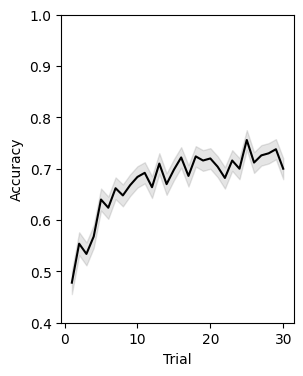

In [17]:
dataset=RW_simulation (alpha=0.3,beta=2, n_trials=30, n_blocks=500)
plotting.plot_accuracy(dataset)

**Question**: is the agent "learning"? How can you tell?

**Exercise:** check what happens as you change the learning rate of the simulation. What happens when you change the inverse temperature?

Another signature that is commonly used in RL is the probability of repeating an action (p(repeat)) depending on whether the last outcome was a reward or not (should I change my behavior in response to feedback?). Let's plot it:

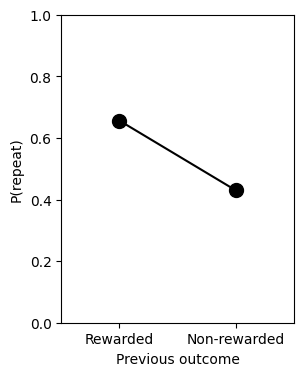

In [18]:
dataset=RW_simulation (alpha=0.3,beta=2, n_trials=30, n_blocks=30)
plotting.plot_prepeat(dataset)

**Question**: is the agent "learning"? How can you tell?

**Exercise:** check again what happens as you change the parameters of the simulation.

## PART 2: PARAMETER FITTING

A key component of computational modeling is estimating the values of the parameters that best describe your behavioral data. There are a number of different ways of estimating parameters, but here we focus on the maximum-likelihood approach.

In the maximum likelihood approach to model fitting, our goal is to find the parameter values of model m ($\theta_m$) that maximize the likelihood of the data, $d_{1:T}$, given the parameters, $p(d_{1:T}|\theta_m)$. For instance, in our RW model the parameters are the learning rate and inverse tempretature ($\theta_{RW}={\alpha,\beta}$, but other models may have different parameters.

Maximizing the likelihood is equivalent to maximizing the log of the likelihood, $LL=log(p(d_{1:T}|\theta_m))$, which is numerically more tractable. (The likelihood is a product of many numbers smaller than 1, which can be rounded to 0 with limited precision computing. By contrast, the log-likelihood is a sum of negative numbers, which is usually tractable and will not be rounded to 0.) A simple mathematical derivation shows that this log-likelihood can be written in terms of the choice probabilities of the individual model as:

$$LL=log(p(d_{1:T}|\theta_m,m))=\sum_{t=1}^{T}log(p(c_t|p(d_{1:t-1},\theta_m,m))$$

where $p(c_t|p(d_{1:t-1},\theta_m,m)$ is the probability of each individual choice ($c_t$) given the parameters of the model ($\theta_m$) and the information available up to that choice ($d_{1:t-1}$). The parameters that we can change (to explain the behavior of different participants) ($\theta_m$) are usually called the "free parameters" of the model.

Let's create a function that calculates the loglikelihood of the data given based on our RW, given a set of parameters. Take a look at the code below and complete the computation of the loglikelihood:

In [19]:
def logl_RW (parameters: list[float],
                       data):
    """
    Calculates the loglikelihood of the dataset based on the Rescorla-Wagner model.

    Inputs:
    parameters: list with the following structure:
        parameters[0]: learning rate
        parameters[1]:inverse temperature
    data: dataset structured as the output of bandit_simulations


    Returns:
    ll: negative loglikelihood of choices given parameters
    """
    # Unpack parameters
    alpha=parameters[0]
    beta=parameters[1]

    #Read number of bandits
    n_bandits = data.shape[2]-3

    #Extract data
    choice = data[:,:,0].astype(int)
    outcome = data[:,:,1]

    #Initialize numpy array to store likelihoods
    likelihood = np.full(data.shape[0:2], np.nan)

    for bb in range(data.shape[0]):
        Q_values=0.5*np.ones(n_bandits) # Initialize Q-values at the beginning of each block
        for tt in range(data.shape[1]):
            # Calculate probability of chosen bandit (based on Q-values)
            p_choice = softmax(beta*Q_values)

            # Update Q-values based on outcome
            Q_values[choice[bb,tt]] += alpha*(outcome[bb,tt]-Q_values[choice[bb,tt]])

            # Store likelihood of choice
            likelihood[bb,tt] = p_choice[choice[bb,tt]] # COMPLETE
    ll=np.nansum(np.log(likelihood)) # COMPLETE
    return ll


Let's simulate an agent with a given pair of parameters and calculate:

In [ ]:
dataset=RW_simulation (alpha=0.3,beta=2, n_trials=30, n_blocks=50)

Now, let's calculate the loglikelihood of the dataset given different sets of parameters.

**Exercise:** what happens to the LL when you use parameters closer to the generating parameters? And when you use parameters that are very different?

In [20]:
alpha=0.3
beta=2
LL=logl_RW ([alpha,beta],dataset)
print("Learning rate used to calculate LL:", alpha)
print("Inverse temperature used to calculate LL:", beta)
print("Loglikelihood of dataset given parameters:", LL)

Learning rate used to calculate LL: 0.3
Inverse temperature used to calculate LL: 2
Loglikelihood of dataset given parameters: -574.3722866188546


So, we need to find the parameters that maximize the loglikelihood of the data given the model. In principle, finding the maximum likelihood parameters is as ‘simple’ as maximizing LL. In practice, of course, finding the maximum of a function is not a trivial process. The simplest approach would be to search the entire parameter space (i.e., try all the possible parameter combinations) and determine which set of parameters maximize the likelihood.

Let's try to do that. Run the cell bellow:

Elapsed time: 126.1435 seconds
Maximum loglikelihood= -572.233
ML parameters
  -Learning rate= 0.28
  -Inverse temperature parameter= 1.70


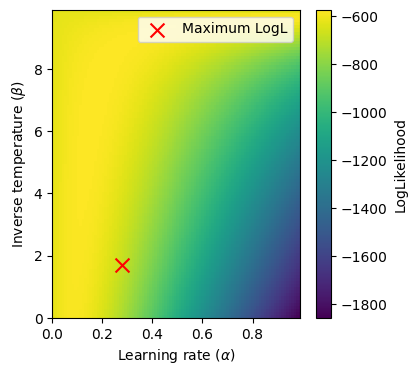

In [21]:
# Generate learning rates between 0 and 1 (step=0.01)
alpha=np.arange(0,1,0.01)
# Generate inverse temperatures between 0 and 10 (step=0.1)
beta=np.arange(0,10,0.1)
# Initialize the numpy array to store LLs
LL=np.full([len(alpha), len(beta)], np.nan)

start_time = time.time()
# Try every learning rate/inverse temperature combination
for a in range(len(alpha)):
    for b in range(len(beta)):
        LL[a,b]=logl_RW([alpha[a],beta[b]],dataset) # Calculate loglikelihood based on each set of parameters

elapsed_time = time.time() - start_time # Time how long the code takes to run
print(f"\rElapsed time: {elapsed_time:.4f} seconds")

#Plot results
plotting.plot_parhm (LL,alpha,beta)

You can see that running the previous code took several seconds/minutes. And this is with a model with just two parameters, but many models have many more parameters, which means that finding the maximum likelihood (ML) parameetrs would be very costly.

Fortunately, a number of tools exist for finding local maxima (and minima) of functions quickly using variations on gradient ascent (or descent). For example, scipy.optimize function can use a variety of sophisticated optimization algorithms to find the **minimum** of a function. So long as one remembers to feed scipy.optimize the negative log-likelihood (whose minimum is at the same parameter values as the maximum of the positive log-likelihood), using tools such as scipy.optimize can greatly speed up model fitting.

Let's try to use this function to find the ML parameters:

**IMPORTANT: remember this function finds minima (NOT maxima), so we need to go back to our logl_RW function and put a minus sign before the output!**

In [32]:
def logl_RW (parameters: list[float],
                       data):
    """
    Calculates the loglikelihood of the dataset based on the Rescorla-Wagner model.

    Inputs:
    parameters: list with the following structure:
        parameters[0]: learning rate
        parameters[1]:inverse temperature
    data: dataset structured as the output of bandit_simulations


    Returns:
    mll: negative loglikelihood of choices given parameters
    """
    # Unpack parameters
    alpha=parameters[0]
    beta=parameters[1]

    #Read number of bandits
    n_bandits = data.shape[2]-3

    #Extract data
    choice = data[:,:,0].astype(int)
    outcome = data[:,:,1]

    #Initialize numpy array to store likelihoods
    likelihood = np.full(data.shape[0:2], np.nan)

    for bb in range(data.shape[0]):
        Q_values=0.5*np.ones(n_bandits) # Initialize Q-values at the beginning of each block
        for tt in range(data.shape[1]):
            # Calculate probability of chosen bandit (based on Q-values)
            p_choice = softmax(beta*Q_values)

            # Update Q-values based on outcome
            Q_values[choice[bb,tt]] += alpha*(outcome[bb,tt]-Q_values[choice[bb,tt]])

            # Store likelihood of choice
            likelihood[bb,tt] = p_choice[choice[bb,tt]] # COMPLETE
    ll=np.nansum(np.log(likelihood)) # store the sum of loglikelihoods
    return -ll


In [36]:
# Define the bounds of the parameters (the function will look for a minima within those bounds)
bounds=scipy.optimize.Bounds(ub=np.array([1,10]),
                                          lb=np.zeros(2))

# Define a starting point to start the search (we can just uniform samples of points within the bounds)
init_par=np.array([np.random.rand(1), 10*np.random.rand(1)])

# Let's calculate the ML parameters
mll=scipy.optimize.minimize(logl_RW, init_par.ravel(), args=dataset,
                     method='L-BFGS-B', bounds=bounds)

print(f'Maximum loglikelihood= {-mll.fun:.3f}')
print('ML parameters')
print(f'  -Learning rate= {mll.x[0]:.2f}')
print(f'  -Inverse temperature parameter= {mll.x[1]:.2f}')

Maximum loglikelihood= -572.221
ML parameters
  -Learning rate= 0.29
  -Inverse temperature parameter= 1.65


**Question:** did the function found the correct maximum likelihood parameters? What happens if you run the function multiple times, do you always get the same result?

A key limitation of optimization algorithms is that they are only guaranteed to find local minima, which are not guaranteed to be the global minima corresponding to the best fitting parameters. One way to mitigate this issue is to run the fitting procedure multiple times with random initial conditions, recording the best fitting log-likelihood for each run. The best fitting parameters are then the parameters corresponding to the run with the highest log-likelihood. There is no hard-and-fast rule for knowing how many starting points to use in a given situation, besides the fact that more complex models will require more starting points.

Let's now define a function that tries to find the maximum likelihood parameters based on our RW model, using several attempts:

In [34]:
def fit_RWmodel(dataset, n_attempts: int =10, ub_beta: float =10):
    """
    Finds the maximum-likelihood parameters based on the Rescorla-Wagner model.

    Inputs:
    dataset: dataset structured as the output of bandit_simulations

    Optional inputs:
    n_attempts: number of attempts to find the minimum (to find the global minimum) (default=10)
    ub_beta: upper bound of the beta parameter (default=10)


    Returns:
    parameters: maxmum likelihood parameters.
    mll: loglikelihood of choices given the maximum likelihood parameters
    """
    tmp_param=[]
    tmp_mll=[]
    bounds=scipy.optimize.Bounds(ub=np.array([1,ub_beta]),
                                          lb=np.zeros(2))
    init_par=np.array([np.random.rand(n_attempts), ub_beta*np.random.rand(n_attempts)])
    for aa in range(n_attempts):

        mle=scipy.optimize.minimize(logl_RW, init_par[:,aa], args=dataset,
                     method='L-BFGS-B', bounds=bounds)
        tmp_param.append(mle.x)
        tmp_mll.append(mle.fun)

    parameters=tmp_param[np.argmin(tmp_mll)]
    mll=np.min(tmp_mll)

    return parameters,-mll

Finally, let's find the ML parameters using this function:|

In [35]:
[[alpha,beta],mll]=fit_RWmodel(dataset)

print(f'Maximum loglikelihood= {mll:.3f}')
print('ML parameters')
print(f'  -Learning rate= {alpha:.2f}')
print(f'  -Inverse temperature parameter= {beta:.2f}')

Maximum loglikelihood= -572.221
ML parameters
  -Learning rate= 0.29
  -Inverse temperature parameter= 1.65


### Parameter recovery

Before reading too much into the best-fitting parameters, it is important to check whether the fitting procedure gives meaningful parameter values in the best case scenario, -that is, when fitting fake data where the ‘true’ parameter values are known. Such a procedure is known as ‘Parameter Recovery’, and is a crucial part of any model-based analysis.

In principle, the recipe for parameter recovery is quite simple. First, simulate fake data with known parameter values. Next, fit the model to these fake data to try to ‘recover’ the parameters. Finally, compare the recovered parameters to their true values. In a perfect world, the simulated and recovered parameters will be tightly correlated, with no bias. If there is only a weak correlation between the simulated and recovered parameters and/or a significant bias, then this is an indication that there is either a bug in your code (which from our own experience is fairly likely) or that the experiment is underpowered to assess this model. Another option is that the model cannot be properly fit (the model parameters are not recoverable), which would mean that we should either consider other models, or create a new experimental design that allow us to recover the parameters.

Let's see if the parameters of our RW model are recoverable. First, let's generate a set of random parameters (learning rates and invere temperatures), and let's generate a data with them:

In [37]:
n_sim=50 #number of simulations
ub_beta=10 #upper bound of inverse temperature parameters

# Generate the parameters
g_parameters=np.array([np.random.rand(n_sim), ub_beta*np.random.rand(n_sim)])

# Generate datasets with the parameters
dataset=[]
for ss in range(n_sim):
    # Each element of the list is the dataset for one agent given a set of parameters
    dataset.append(RW_simulation (alpha=g_parameters[0,ss],beta=g_parameters[1,ss], n_trials=30, n_blocks=50))

Now let's fit the datasets to get the maximum likelihood parameters:

In [ ]:
# Initialize array to save the maximum likelihood parameters
mll_parameters=np.full(g_parameters.shape,np.nan)

# Find the best fitting paramaters for each dataset
for ss in tqdm(range(len(dataset)), desc='Fitting data:'):
    [mll_parameters[:,ss],_]=fit_RWmodel(dataset[ss])

Finally, compare the generating parameters to the fitted parameters to see if the model parameters are recoverable.

**Question:** what do you think, are the model parameters recoverable?

In [ ]:
plotting.plot_recovery(g_parameters,mll_parameters,labels=[r'Learning rate ($\alpha$)', r'Inverse temperature ($\beta$)'])

## PART 3: MODEL COMPARISON

In model comparison, our goal is to determine which model, out of a set of possible models, is most likely to have generated the data. To illustrate this, we will import a synthetic dataset (i.e., simulated), and we will try to determine which model was more likely to generate it. We will check which of three models explains the dataset better:

### Model 1: Random responding

In the first model, we assume that participants do not engage with the task at all and simply press buttons at random, perhaps with a bias for one option over the other. Such random behavior is not uncommon in behavioral experiments, especially when participants have no external incentives for performing well. Modeling such behavior can be important if we wish to identify such ‘checked out’ individuals in a quantitative and reproducible manner, either for exclusion or to study the checked-out behavior itself. To model this behavior, we assume that participants choose between the two options randomly, perhaps with some overall bias for one option over the other. This bias is captured with a parameter $b$ (which is between 0 and 1), such that the probability of choosing the two options is:

$$p^1_t=b$$

$$p^2_t=1−b$$

Thus, for two bandits, the random responding model has just one free parameter, controlling the overall bias for option 1 over option 2 ($\theta_1=b$)


### Model 2: Noisy win-stay-lose-shift

The win-stay-lose-shift model is one of the simplest models that adapts its behavior according to feedback. Consistent with the name, the model repeats rewarded actions and switches away from unrewarded actions. In the noisy version of the model, the win-stay-lose-shift rule is applied probabilistically, such that the model applies the win-stay-lose-shift rule with probability $1−\epsilon$, and chooses randomly with probability $\epsilon$. In the two-bandit case, the probability of staying (i.e., of repeating the same choice from the last trial) is:


$$p_t(stay) = \begin{cases}
    1-\epsilon/2 & \text{ if } R_{t-1}=1 \\
    \epsilon/2 & \text{ if } R_{t-1}=0
\end{cases}$$

Although more complex to implement, this model still only has one free parameter, the overall level of randomness, ($\theta_2=\epsilon$).


### Model 3: Rescorla-Wagner model

Finally, this is the Rescorla-Wagner model that we have already studied, with two parameters, the learning rate $\alpha$ and the inverse temperature parameter $\beta$ ($\theta_3$={$\alpha$,$\beta$}).

A simplistic approach to model comparison would be to compare the log-likelihoods of each model at the best fitting parameter settings, $p(d_{1:T}|\theta_m)$. Let's try to do that.

First lest load the mystery_model dataset:

In [ ]:
# Load and organize data so that the datasets of the different participants are organized in a list
load_data=np.load('mystery_dataset.npy')
dataset=[]
for ss in range(load_data.shape[3]):
    dataset.append(load_data[:,:,:,ss])

Now, let's fit the dataset to our three hypothesis models:

In [ ]:
# Initialize arrays to store the maximum loglikelihoods and the parameters
mll=np.full(np.array([len(dataset),3]), np.nan)
parameters=[]
parameters.append(np.full([len(dataset),1], np.nan))
parameters.append(np.full([len(dataset),1], np.nan))
parameters.append(np.full([len(dataset),2], np.nan))

# Fit each participant of the dataset with our 3 models
for ss in tqdm(range(len(dataset))):
    [parameters[0][ss],mll[ss,0]]=models.fit_REmodel(dataset[ss])
    [parameters[1][ss],mll[ss,1]]=models.fit_WSLSmodel(dataset[ss])
    [parameters[2][ss,:],mll[ss,2]]=models.fit_RWmodel(dataset[ss])

Let's now plot the mean maximum loglikelihoods for each model:

**Question:** which models seem to explain the data best?

In [ ]:
plotting.my_barplot(mll,['RE','WSLS','RW'],'Mean MLL')

However, if the data, used to evaluate the log-likelihood are the same as those used to fit the parameters, then this approach will lead to overfitting, as the model with the most free parameters will almost always fit this ‘training’ data best. As an extreme example, consider the case of a model with one ‘parameter’ per choice, which is the identity of the choice the person actually made. Such a ‘model’ would fit the data perfectly, but would of course tell us nothing about how the choices were actually determined and would make no predictions about what choices would be made in a different setting. Overfitting is a problem in that it decreases the generalizability of the model: it makes it less likely that the conclusions drawn would apply to a different sample.

One way to avoid overfitting is to approximately account for the degrees of freedom in the model (e.g., number of parameters, number of measurements...). There are several methods for doing this, but a very common and simple method is the Bayes Information Criterion, BIC, which has an explicit penalty for free parameters.

$$BIC=−2*logLL+k_{m}*log(T)$$

where LL is the log-likelihood value at the best fitting parameter settings, $T$ is the number of datapoints (i.e., number of trials in the data) and $k_m$ is the number of parameters in model $m$. The model with the smallest BIC score is the model that best fits the data. Thus, the positive effect of km in the last term corresponds to a penalty for models with large numbers of parameters.

Let's create a function that calculates the BIC:

In [ ]:
def get_BIC (mll,n_params,n):

    """
    Calculates the BIC.

    Input:
    mll: array containing maximum likelihoods where the first dimention corresponds to the different participants,
        and the second dimension corresponds to each of the tested models
    n_params: array with the number of parameters of each model
    n: number of datapoints for each subject

    Output:
    bic: array with the same dimentions as mll, with the AIC of each model for each subject.
    """

    bic = np.log(n)*n_params - 2*mll #COMPLETE

    return bic

Let's now calculate the BIC for the different models:

**Question:** which model better explains the dataset best now?

In [ ]:
bic=get_BIC(mll,np.array([1,1,2]),dataset[0][:,:,0].size)
plotting.my_barplot(bic,['RE','WSLS','RW'],'BIC')

### Note: we shouldn't rely on model comparison methods only!

Even though model comparison can very useful tool, it's important to remember that it does not tell us **which model generated the data**, it just tells us **which model best explains the data**. We should therefore combine this tool with other analyses that allow us to tell our models apart. A very useful approach is to check whether different models predict different behavioral signatures. If the behavior of different models is not qualitatively different, this is a sign that you should try to design a better experiment. Although not always possible, distinguishing between models on the basis of qualitative patterns in the data is always preferable to quantitative model comparison.

For example, we can take the best fitting parameters of each model, and use them to simulate behavior. This will generate a dataset for each model, which will represent the behavior that we would observe if all our "participants" followed that model strictly:

In [ ]:
# Initialize the lists to store the simulations of each model
RE_sim=[]
WSLS_sim=[]
RW_sim=[]

# Simulate the different models (given their corresponding best fitting parameters) for each participant
for ss in range(len(dataset)):
    RE_sim.append(models.RE_simulation(b=parameters[0][ss][0]))
    WSLS_sim.append(models.WSLS_simulation(eps=parameters[1][ss][0]))
    RW_sim.append(models.RW_simulation(alpha=parameters[2][ss,0],beta=parameters[2][ss,1]))

And now we can see if the different models predict different behavioral signatures. For instance, let's look again at the probability of repeating a choice as a function of feedback:

**Question:** do the dfferent models predict qualitatively different signatures?

In [ ]:
# Plot the predicted probability of repeat for each model
fig,ax = plt.subplots(figsize=(3, 4))
plotting.plot_prepeat(RE_sim,ax=ax, color='maroon', label='RE')
plotting.plot_prepeat(WSLS_sim,ax=ax, color='gold', label='WSLS')
plotting.plot_prepeat(RW_sim,ax=ax, color='teal', label='RW')
ax.legend()

Finally, let's see what is the actual behavior in the dataset:

**Question:** is any of the models predicting the behavioral signature of the dataset with high fidelity?

In [ ]:
# Plot the model predictions alongside the data
fig,ax = plt.subplots(figsize=(3, 4))
plotting.plot_prepeat(RE_sim,ax=ax, color='maroon', label='RE')
plotting.plot_prepeat(WSLS_sim,ax=ax, color='gold', label='WSLS')
plotting.plot_prepeat(RW_sim,ax=ax, color='teal', label='RW')
plotting.plot_prepeat(dataset,ax=ax, color='k', label='data')
ax.legend()

## PART 4: EXAMPLE WITH REAL BEHAVIOR

Let's now used what we have learned to analyse a real human behavior! We will use the dataset from [Palminteri et al. (PLOS, 2017)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005684#sec010), where participants completed a two-armed bandit task. We have data from 50 participants, so let's try to model their behavior.

First things first, let's load the dataset:

In [ ]:
#Load the dataset
load_dataset=scipy.io.loadmat("P_dataset.mat")
load_dataset=load_dataset['dataset']

# Let's structure the dataset in a list, like we have done so far.
P_data=[]
for ss in range(load_dataset.shape[3]):
    P_data.append(load_dataset[:,:,:,ss])

Again, let's try to fit our data with the three models from our models comparison section:

In [ ]:
mll=np.full(np.array([len(P_data),3]), np.nan)
parameters=[]
parameters.append(np.full([len(P_data),1], np.nan))
parameters.append(np.full([len(P_data),1], np.nan))
parameters.append(np.full([len(P_data),2], np.nan))

# Fit each participant of the dataset with our 3 models
for ss in tqdm(range(len(P_data))):
    [parameters[0][ss],mll[ss,0]]=models.fit_REmodel(P_data[ss])
    [parameters[1][ss],mll[ss,1]]=models.fit_WSLSmodel(P_data[ss])
    [parameters[2][ss,:],mll[ss,2]]=models.fit_RWmodel(P_data[ss])

We can now look at the BIC.

**Question:** which model provides a best description of the data according to this measure? Does this mean that we can be sure that participants are using this model when completing the task?

In [ ]:
# Calculate and plot the BIC for the different models
bic=get_BIC(mll,np.array([1,1,2]),P_data[0][:,:,0].size)
plotting.my_barplot(bic,['RE','WSLS','RW'],'BIC')

We can now take a look at the parameters of the winning model to see how they are distributed across participants. These parameetrs provide a compressed representation of how our participants learn in the task. In our experiment, we could use this parameters in many ways (to check if they change in different conditions, to see if they correlate with certain psychiatric dimensions or neural signatures, etc.).

In [ ]:
# plot the parameters of the winning model
fig,ax = plt.subplots(1,2,figsize=(6, 4))
plotting.plot_parameters(parameters[2][:,0], labels=[r'$\alpha$'], colors='teal', ax=ax[0])
plotting.plot_parameters(parameters[2][:,1], labels=[r'$\beta$'], colors='mediumpurple',ax=ax[1])
plt.ylabel('')

Remember that it's always good practice look at some behavioral signatures to see if our models predict participants' behavior! Let's look again at the probability of repeating a choice depending on the feedback received.

We first need to create simulations for each model based on the best fitting parameters of the participants. This will give as an estimation of what behavior we would observer if all participants were following a given model.

In [ ]:
# Simulate behavior based on our hypothesis models
RE_sim=[]
WSLS_sim=[]
RW_sim=[]
for ss in range(len(P_data)):
    RE_sim.append(models.RE_simulation(b=parameters[0][ss][0]))
    WSLS_sim.append(models.WSLS_simulation(eps=parameters[1][ss][0]))
    RW_sim.append(models.RW_simulation(alpha=parameters[2][ss,0],beta=parameters[2][ss,1]))

Now, let's look at the probability of repeating a choice:

**Question:** what model best predicts participants behavior? Does that model provide a very accurate prediction of participants behavior?

In [ ]:
# Plot the probability of repeat based on our model simulations and on the actual data
fig,ax = plt.subplots(figsize=(3, 4))
plotting.plot_prepeat(RE_sim,ax=ax, color='maroon', label='RE')
plotting.plot_prepeat(WSLS_sim,ax=ax, color='gold', label='WSLS')
plotting.plot_prepeat(RW_sim,ax=ax, color='teal', label='RW')
plotting.plot_prepeat(P_data,ax=ax, color='k', label='data')
ax.legend()

As you can see the prediction of our winning model does not exactly follow the real behavior of participants. There could be several reasons for this, including noise and the fact that different participants may be following different strategies. However, this could also mean that our hypothesis model is missing a key element of the phenomenon we are trying to describe. In order to see if this is the case, we should try other behavioral signatures, take a close look at how the models work and design a new (more complete model).

**Question:** could you think of a possible modification that would better account for participants' behavior?

One posibility is that participants don't learn equally from rewards an non-rewards. This is, they have a feedback valence bias where they learn more from positive/negative feedback than from its counterpart. A model that could account for this could be something like this:

### Model 4: Rescorla Wagner with valence bias

This model very similar to our Rescorla Wagner model, but with one key difference: it uses different learning rates when the feedback is rewarding, and when it is non-rewarding. Therefore our learning rule would look something like this:


$$\delta_t = R_t - Q_t(a_t)$$

$$Q_{t+1}(a_t) = \begin{cases}
    Q_t(a_t) + \alpha_+*\delta_t & \text{ if } \delta_t>0 \\
    Q_t(a_t) + \alpha_-*\delta_t & \text{ if } \delta_t<0
\end{cases}$$

According to this model, positive prediction errors (i.e., $\delta_t$>0, which happens when we get an outcome greater than expected) can be incorporated into our Q-values at a different rate than negative prediction errors ($\delta_t$<0, which happen when we get an outcome lower than expected). The free parameter $\alpha_+$ is the learning rate for positive prediction errors, while the free parameters $\alpha_-$ is the learning rate for negative prediction errors.

Action selection is still computed by feeding the Q-values into a softmax with its corresponding inverse temperature parameter ($\beta$). This model has therefore three parameters ($\theta=\{\alpha_-,\alpha_+,\beta\}$).

Let's now fit this model:

In [ ]:
# Increase our mll and parameters variables so that we can store the new model fitting information
mll=mll[:,0:3]
mll=np.hstack((mll,np.full(np.array([len(P_data),1]), np.nan)))
parameters.append(np.full([len(P_data),3], np.nan))

# Fit each participant of the dataset with our new model
for ss in tqdm(range(len(P_data))):
    [parameters[3][ss,:],mll[ss,3]]=models.fit_RWvalmodel(P_data[ss])

We can again look at the BIC to see if this model gives a better description of our data:

In [ ]:
# Calculate and plot the BIC for our previour winning model and our new model
bic=get_BIC(mll[:,2:],np.array([2,3]),P_data[0][:,:,0].size)
plotting.my_barplot(bic,['RW','RWval'],'BIC')

Also, we can compute some simulations based on this model (again with the best fitting parameters from participants). We can then look again at our behavioral signature.

In [ ]:
# Simulate behavior based on our new RW valence model
RWval_sim=[]
for ss in range(len(P_data)):
    RWval_sim.append(models.RWval_simulation(alpha_neg=parameters[3][ss,0],alpha_pos=parameters[3][ss,1],beta=parameters[3][ss,2]))

In [ ]:
# Plot the probability of repeat based on our model simulations and on the actual data
fig,ax = plt.subplots(figsize=(3, 4))
plotting.plot_prepeat(RW_sim,ax=ax, color='teal', label='RW')
plotting.plot_prepeat(RWval_sim,ax=ax, color='hotpink', label='RWval')
plotting.plot_prepeat(P_data,ax=ax, color='k', label='data')
ax.legend()

**Question:** taking all of this into account, can we say that this model seems to give a better description of participants' behavior?

Finally, let's look at the parameters from the model.

**Question:** do you notice something interesting in the parameters? Do participants' show a bias in learning? in what way?

In [ ]:
# Plot the model parameters of our RW valence model
fig,ax = plt.subplots(1,2,figsize=(6, 4))
plotting.plot_parameters(parameters[3][:,0:2], labels=[r'$\alpha_-$',r'$\alpha_+$'], colors=['red', 'green'], ax=ax[0])
plotting.plot_parameters(parameters[3][:,2], labels=[r'$\beta$'], ax=ax[1])
plt.ylabel('')

plotting.plot_parameters(parameters[3][:,1]-parameters[3][:,0], labels=[r'$\alpha_+$ - $\alpha_-$'], colors=['orange'])


## Congratulations! You finished the modelling workshop.

This was just a taster of what modelling allows. There are many more methods and models that can be used to study many aspects of human behavior (and cognition). If you want you can take a look at the paper that inspired this workshop ([Ten simple rules for the computational modeling of behavioral data](https://elifesciences.org/articles/49547) or at [Reinforcement learning: an Introduction (Sutton and Barto)](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf), (i.e., the holly Bible of RL research). The next step is to take what you have learned, extend it, and apply it to your own research. Good luck!

And remember...

![alt text](https://github.com/Juan-VidalPerez/Modelling_workshop/blob/main/all_models.jpeg?raw=1)